# Velocity and pumping diagnostics after PharaGlow analysis

## Changing names (user input required)

#### Strain directories

In [1]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/"
INF100 = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/INF100/"
INF102 = "/media/scholz_la/soma/Nicolina/INF102/RFP_24h/10x/10x_INF102_analyzed/"

# FINAL FIGURE NAME AND DIRECTORY (figure name MUST have .pdf at the end) - if not changed the previous figure
# WILL be erased so be careful!
figurename = "/home/nzjacic/Desktop/10x_concentration_diagnostics.pdf"

#### Dictionary linking strain names to their folders and graph colors

In [29]:
# ADD STRAIN NAMES
strains = ['Control', 'INF100', 'INF102']

# ADD DIRECTORY VARIABLE
directories = [ctrl, INF100, INF102]

# ADD COLORS
# if a syntax error comes up it's probably because you forgot to add a comma after the previous strain name
colors = {
        'INF100':'red',
        'Control':'blue',
        'INF102' :'green'
    }

In [25]:
dicts

[{'Control': '/media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/',
  'INF100': '/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/INF100/',
  'INF102': '/media/scholz_la/soma/Nicolina/INF102/RFP_24h/10x/10x_INF102_analyzed/'},
 {'INF100': 'red', 'Control': 'blue', 'INF102': 'green'},
 {'xlabel': 'Time(s)',
  'ylabelv': 'Velocity (um/s)',
  'ylabelp': 'Pumping rate (Hz)'}]

#### Variables

In [5]:
# # NUMBER OF ROWS IN FIGURE - CHANGE TO TOTAL NUMBER OF STRAINS
# figRows = 3

# IS THERE A LAWN?
lawn = 'Yes' #or 'No'

# FPS?
fps = 30

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

## Extracting velocity and pumping information

### Importing packages

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import extract, util
from pharaglow.util import smooth

### Defining functions and dictionaries

#### Defining functions to extract velocity, pumping and kymo

In [7]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(traj):
    return extract.bestMatchPeaks(traj['pumps'])

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

#### Defining how Python reads in Pharaglow and lawn data

In [9]:
%%time
def readData(dataFolder, umPerPx, fps, j = 0, nmax = None):
    df = {}
    lawnImages = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        if nmax != None and len(df.keys())>nmax-1:
            break
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            p, pump, pks, roc  = getPumps(traj)
            # interpolate the pumping rate
            pumpingrate = fps/np.diff(p)
            pumpInterp = np.interp(traj['frame'], p[:-1], pumpingrate, left = 0, right = 0)
            # get kymo
            kymo = getKymo(traj, 'Straightened')
            df[j] = {'time': t,
                     'x': traj['x'],
                     'y': traj['y'],
                             'velocity':v,
                             'peaks': p,
                             'pumpTrace':pump.values,
                             'pumpRate':pumpingrate,
                             'pumpInterpolated': pumpInterp,
                             'inside': traj['inside'],
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo
                                 }
            j +=1
    return df

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 14.8 µs


#### Reading in Pharaglow results for different strains/conditions

In [30]:
%%time

# Making dictionary combining data with strain name in their separate master folders
Data = {}
for strainName, folder in zip(strains, directories):
    Data[strainName] = readData(folder, umPerPx, fps, nmax = 1)

Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/20200326_NZ0047_test_results_14.json


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  if sys.path[0] == '':


Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/INF100/NZ0046_results_0.json
Reading /media/scholz_la/soma/Nicolina/INF102/RFP_24h/10x/10x_INF102_analyzed/NZ0099_results_17.json
CPU times: user 45.5 s, sys: 6.49 s, total: 52 s
Wall time: 1min


## Plotting (user input required)

Beginning analysis for Control:
Control trajectory 0
Plotting Control...
Beginning analysis for INF100:
INF100 trajectory 0
Plotting INF100...
Beginning analysis for INF102:
Plotting INF102...


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (1200,) and (1,)

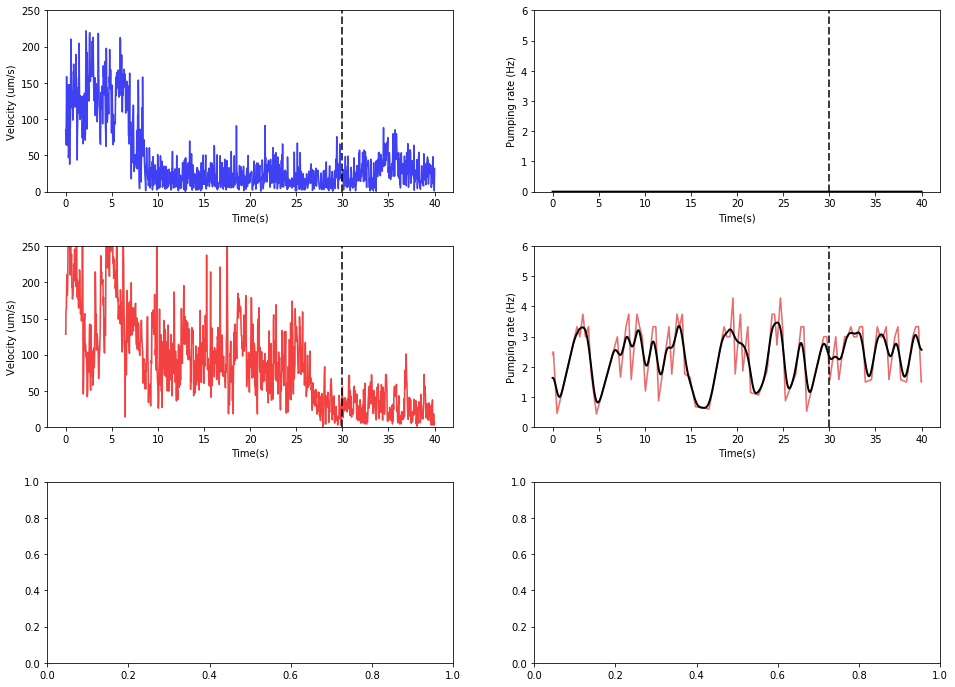

In [39]:
# ASSIGNING TIME BEFORE ENTRY (dt) AND TIME AFTER ENTRY (da) INTO THE LAWN
dt = 900
da = 300

# setting up GridSpec
f1 = plt.figure(figsize = (16,12))
grid = mpl.gridspec.GridSpec(ncols=2, nrows = len(strains), hspace = 0.3)

# SETTING UP SUBPLOTS - ADD TO AS NUMBER OF STRAINS INCREASE
# (a) velocity
ax1a = f1.add_subplot(grid[0,0])
ax2a = f1.add_subplot(grid[1,0])
ax3a = f1.add_subplot(grid[2,0])
axa = [ax1a, ax2a, ax3a]
# (b) pumping
ax1b = f1.add_subplot(grid[0,1])
ax2b = f1.add_subplot(grid[1,1])
ax3b = f1.add_subplot(grid[2,1])
axb = [ax1b, ax2b, ax3b]

# axes dictionary
axes = {
    'xlabel':'Time(s)',
    'ylabelv':'Velocity (um/s)',
    'ylabelp':'Pumping rate (Hz)'
}

# plotting velocity and pumping
if lawn is 'Yes':
    # goes through each condition
    for ci, condition in enumerate(Data.keys()):
        print('Beginning analysis for', condition+':')
        # lists needed for plotting
        cutVelocities = []
        pumpingrates = []
        pumpingInterp = []
        # goes through each worm
        for idx in Data[condition].keys():
            f = (Data[condition][idx]['inside']).mean()
            if f<0.9 and f>0.01:
                t0 = np.where(Data[condition][idx]['inside'] ==1)[0][0]
                if t0>dt and t0-dt>0 and t0+da<len(Data[condition][idx]['time']):
                    print(condition, 'trajectory', idx)
                    # velocity variables
                    time = np.linspace(0, (dt+da)/fps, dt+da)
                    cutVelocities.append(Data[condition][idx]['velocity'][t0-dt:t0+da])
                    # pumping variables
                    pumpingrates.append(Data[condition][idx]['pumpInterpolated'][t0-dt:t0+da])
        print ('Plotting', condition+'...')
        # average velocity across all trajectories and all movies per strain
        mv, sv = np.mean(np.array(cutVelocities), axis =0), np.std(np.array(cutVelocities), axis =0)
        axa[ci].plot(time, mv, color = colors[condition], alpha = 0.7)
        axa[ci].fill_between(np.arange(len(mv))/fps, mv-sv, mv+sv, 
                             color = 'gray', alpha = 0.3)
        # making it pretty
        axa[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
        axa[ci].set_ylabel(axes['ylabelv'])
        axa[ci].set_xlabel(axes['xlabel'])
        axa[ci].set_ylim(0,250)
        # average pumping rate across all trajectories and all movies per strain
        mp, sp = np.mean(np.array(pumpingrates), axis =0), np.std(np.array(pumpingrates), axis =0)
        axb[ci].plot(time, mp, color = colors[condition], alpha = 0.5)
        axb[ci].fill_between(np.arange(len(mp))/fps, mp-sp, mp+sp, 
                 color = 'gray', alpha = 0.3)
        axb[ci].plot(time, smooth(np.array(pumpingrates[-1]), 50), 'black', lw =2)
        axb[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
        axb[ci].set_ylabel(axes['ylabelp'])
        axb[ci].set_xlabel(axes['xlabel'])
        axb[ci].set_ylim(0,6)
# adding titles
ax1a.set_title('Average Velocity of Trajectories per Video')
ax1b.set_title('Pumping Rate (Hz) of Trajectories per Video')

print('Ta da!')

# OPTIONAL - save figure
# plt.savefig(figurename)